In [1]:
import threading, cv2, time
import socket
%matplotlib inline
import matplotlib.pyplot as plt

import cPickle as pickle
import numpy as np
import tensorflow as tf


with open("read_data.pickle", "r") as f:
    x = pickle.load(f)
    train_pics = x["pics"]
    train_labels = x["labels"]
    
print train_pics.shape, train_labels.shape
train_pics = (train_pics -128)/256.0

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_pics, train_labels = randomize(train_pics, train_labels)
print "shuffle done"



(132, 480, 640, 3) (132, 4)
shuffle done


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


batch_size = 64
patch_size1 = 10
patch_size2 = 5
depth1 = 9
depth2 = 24
num_hidden = 128
image_height = 480
image_width = 640
num_channels = 3
num_labels = 4

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
#   tf_valid_dataset = tf.constant(valid_dataset)
  
  tf_test_data = tf.placeholder(
    tf.float32, shape=(1, image_height, image_width, num_channels))
    
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size1, patch_size1, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size2, patch_size2, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [6384, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 4, 4, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 2, 2, 1], padding='VALID')
    bias2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(bias2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
 
  with tf.device("/gpu:0"):
      # Training computation.
      logits = model(tf_train_dataset)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
        
      test_prediction = tf.nn.softmax(model(tf_test_data))
    
  saver = tf.train.Saver()

Initialized
prediction: 3
label:  3


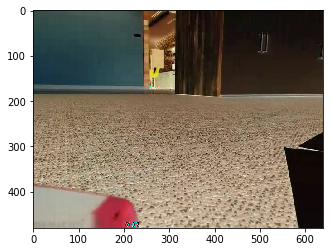

prediction: 0
label:  0


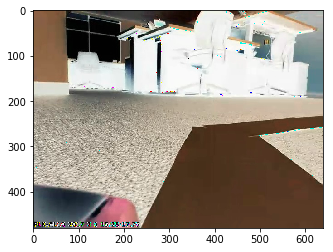

prediction: 3
label:  3


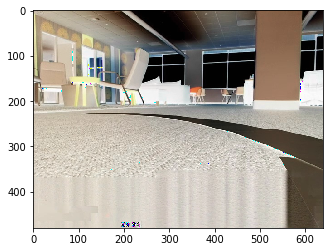

prediction: 1
label:  1


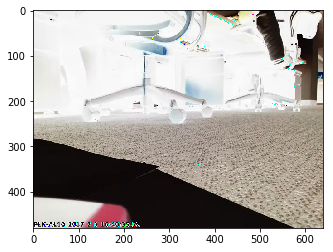

prediction: 3
label:  3


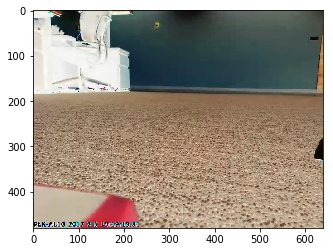

prediction: 1
label:  3


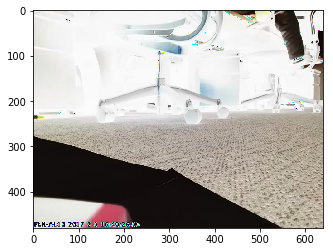

prediction: 3
label:  3


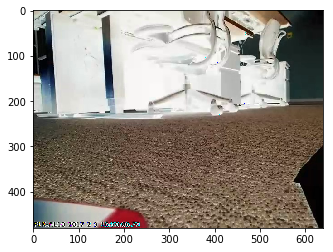

prediction: 1
label:  1


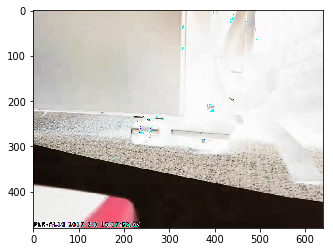

prediction: 2
label:  2


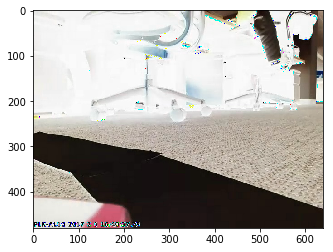

prediction: 3
label:  3


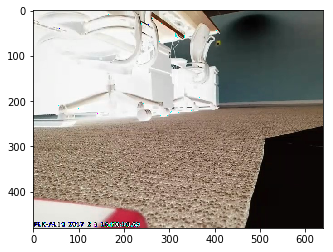

prediction: 2
label:  2


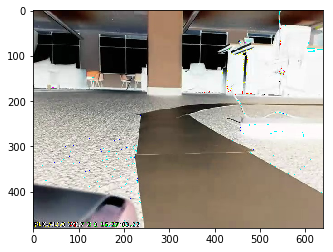

prediction: 3
label:  3


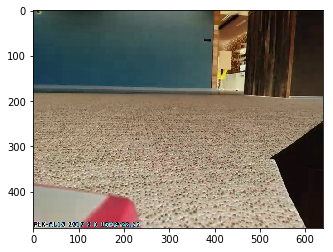

prediction: 2
label:  2


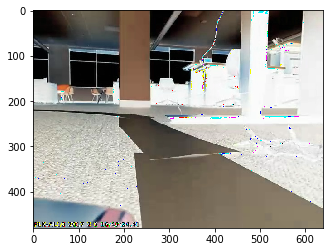

prediction: 1
label:  1


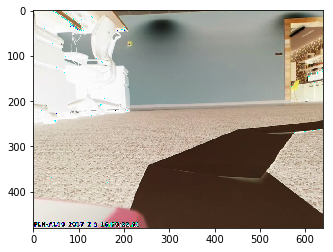

prediction: 1
label:  1


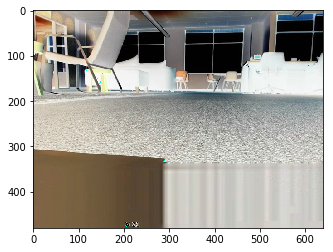

In [13]:
with tf.Session(graph=graph) as session:
    saver.restore(session, "./model-300.ckpt")
    print('Initialized')
    for test_num in range(15):
        feed_dict = {tf_test_data: np.array([train_pics[test_num]])}
        prediction = session.run(test_prediction, feed_dict=feed_dict)
        prediction = list(prediction[0])
        print "prediction: " + str(prediction.index(max(prediction)))

        plt.imshow(train_pics[test_num] * 256.0 + 128.0)
        print "label:  " + str(list(train_labels[test_num]).index(max(train_labels[test_num])))
        plt.show()


Initialized


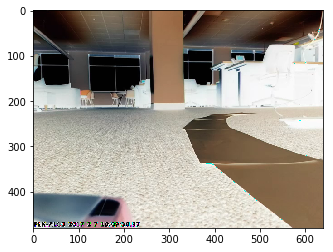

[0.93569618, 0.0030527168, 0.0039569102, 0.057294153]
ff


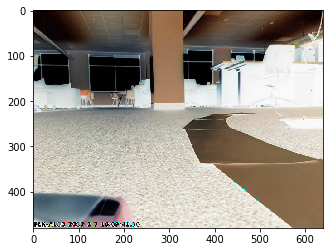

[0.91887325, 0.0031476629, 0.0038008478, 0.074178189]
ff


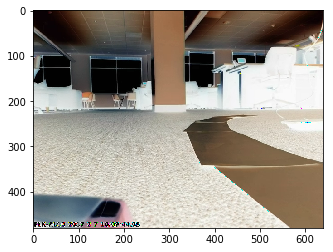

[0.95772654, 0.0025300814, 0.0033485005, 0.036394842]
ff


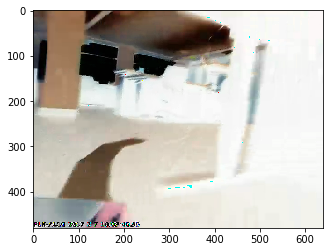

[0.068483382, 0.72398084, 0.10554564, 0.10199019]
bb


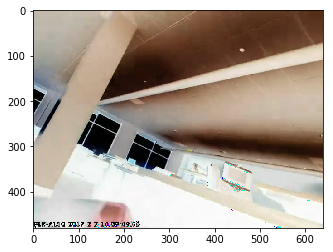

[0.10335309, 0.77882427, 0.046922352, 0.070900261]
bb


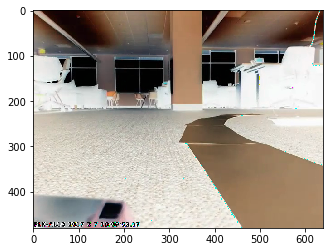

[0.83100927, 0.089687951, 0.044703767, 0.034599077]
ff


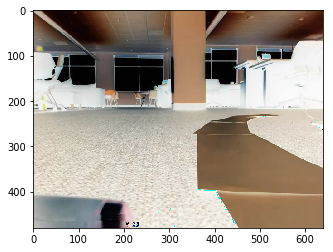

[0.62271321, 0.18440557, 0.020090301, 0.17279088]
ff


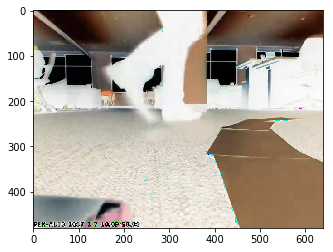

[0.95700586, 0.019118644, 0.0054804049, 0.018395077]
ff


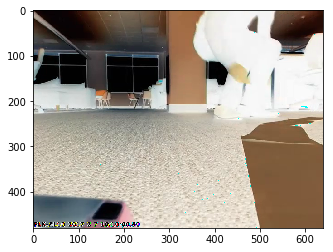

[0.44110361, 0.0040557175, 0.015806504, 0.53903413]
rr


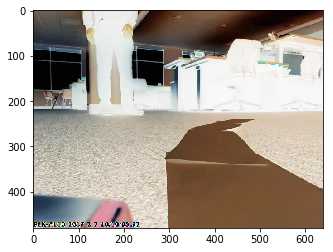

[0.046851389, 0.091478489, 0.83886802, 0.022802066]
ll


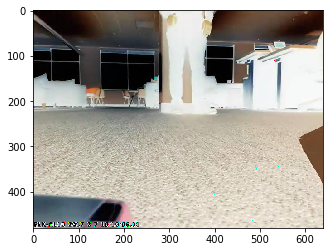

[0.12707907, 0.066878535, 0.10412864, 0.70191377]
rr


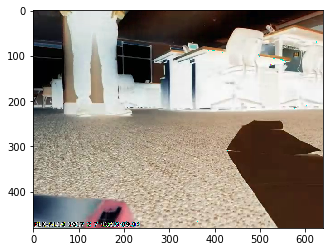

[0.36109927, 0.11867001, 0.01538269, 0.504848]
rr


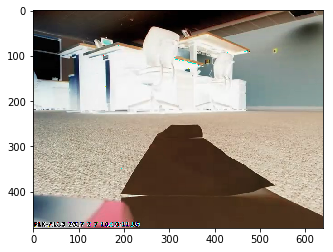

[0.041682724, 0.24843399, 0.69973361, 0.010149634]
ll


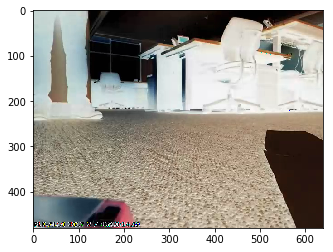

[0.042283241, 0.037263729, 0.1381439, 0.78230906]
rr


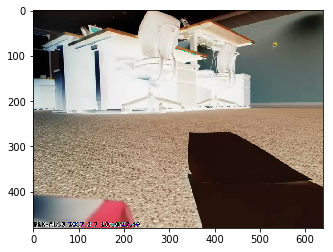

[0.14794761, 0.039471053, 0.13704935, 0.67553198]
rr


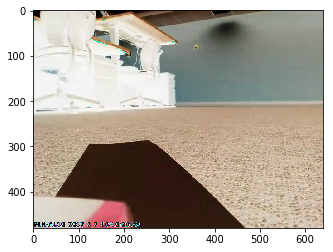

[0.0003386428, 0.99140316, 0.0056650722, 0.0025932051]
bb


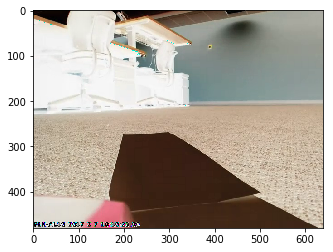

[0.022870714, 0.64626259, 0.32716995, 0.0036967862]
bb


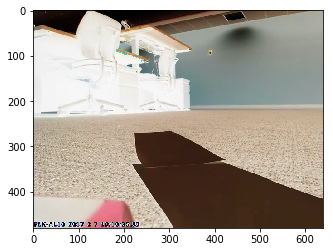

[0.070802815, 0.12543595, 0.798392, 0.0053692567]
ll


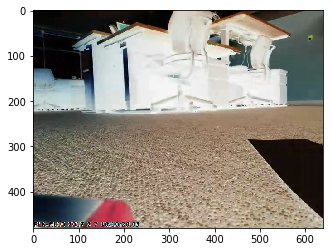

[0.04467896, 0.050912958, 0.0093448022, 0.89506328]
rr


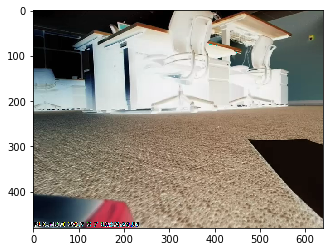

[0.035785228, 0.069345728, 0.011508681, 0.88336033]
rr


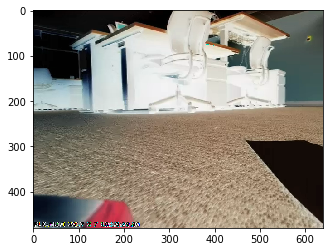

[0.086608142, 0.196127, 0.021180917, 0.69608396]
rr


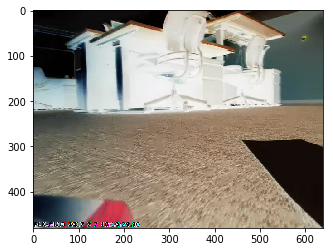

[0.069212727, 0.11356711, 0.066383377, 0.75083685]
rr


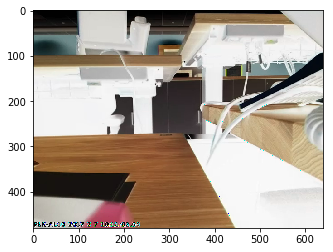

[0.027361022, 0.21012293, 0.69169676, 0.070819266]
ll


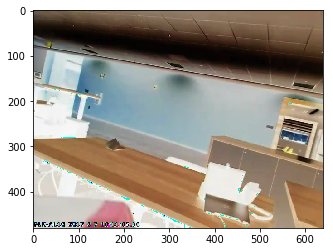

[0.63718975, 0.10014234, 0.014563689, 0.24810418]
ff


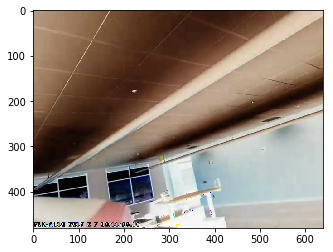

[0.010432444, 0.54536688, 0.0033210439, 0.44087955]
bb


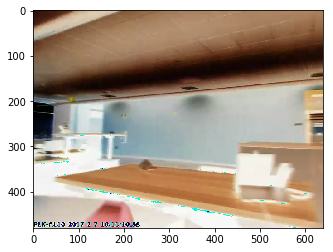

[0.45856252, 0.16009252, 0.014315556, 0.36702943]
ff


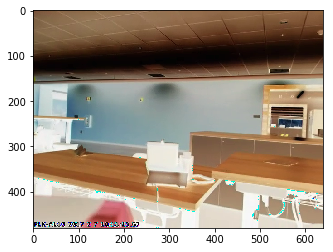

[0.42693076, 0.085175425, 0.0029034307, 0.48499039]
rr


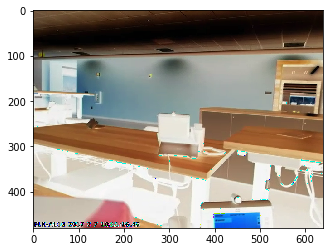

[0.086743355, 0.61131006, 0.24989042, 0.052056156]
bb


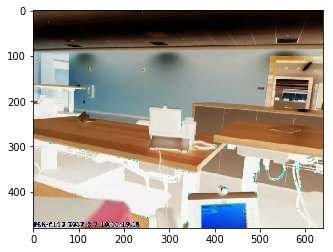

[0.36773914, 0.23162703, 0.3857657, 0.014868062]
ll


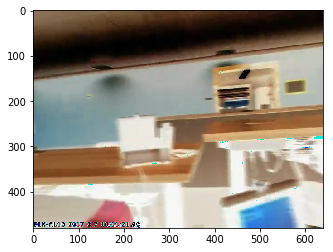

[0.025206452, 0.88197333, 0.017426521, 0.075393721]
bb


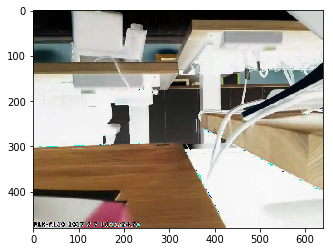

[0.0069925883, 0.50637341, 0.4696801, 0.016953826]
bb


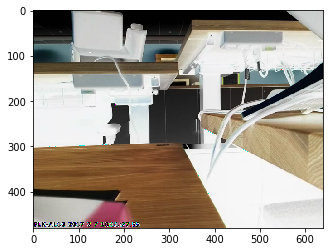

[0.0023645349, 0.47331598, 0.5096426, 0.014676889]
ll


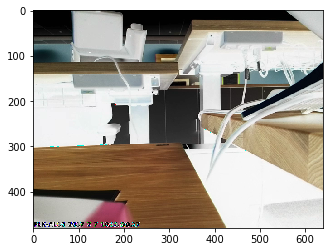

[0.0042288266, 0.58505231, 0.3872233, 0.023495609]
bb


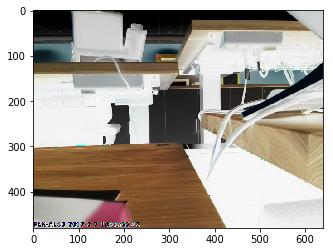

[0.0025743423, 0.75847852, 0.22999863, 0.0089484453]
bb


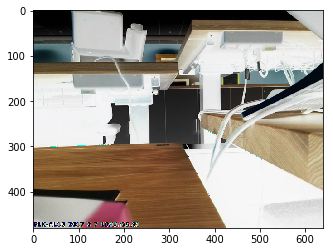

[0.0039816182, 0.62652528, 0.36235562, 0.0071375528]
bb


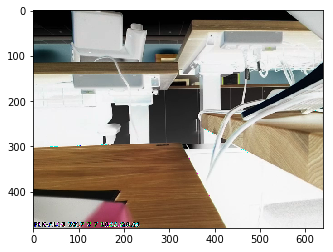

[0.0034332762, 0.6857391, 0.29600406, 0.014823537]
bb


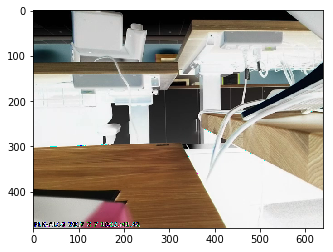

[0.0074554803, 0.59859669, 0.38838756, 0.0055602635]
bb


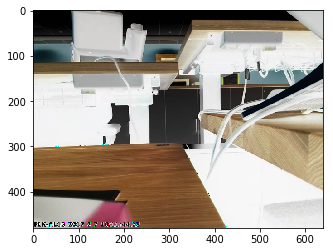

[0.0022242125, 0.80310494, 0.18465327, 0.010017551]
bb


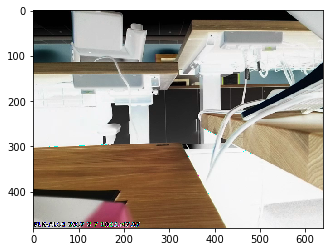

[0.0016413609, 0.68154025, 0.30918214, 0.0076363361]
bb


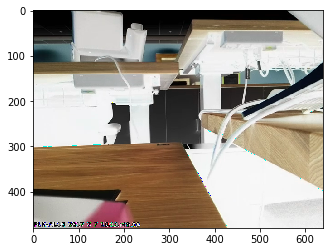

[0.0026096052, 0.23150215, 0.76048321, 0.0054050414]
ll


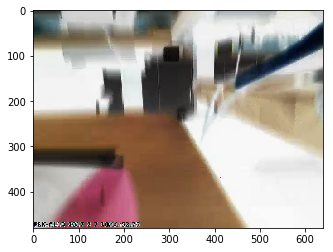

[0.23351726, 0.013010208, 0.71278536, 0.04068708]
ll


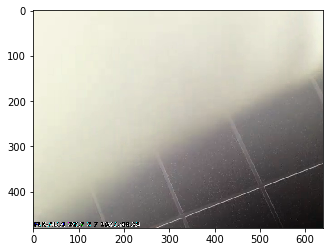

[0.48035854, 0.42654073, 0.084877551, 0.008223163]
ff


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [11]:
class Grabber(threading.Thread):
    def __init__(self, cam):
        threading.Thread.__init__(self)
        self.cam = cam
        self.lock = threading.Lock()
        self.running = True
        self.start()
    def run(self):
        while self.running:
            time.sleep(0.01)
            with self.lock:
                self.cam.grab()
    def stop(self):
        self.running = False
    def retrieve(self):
        with self.lock:
            return self.cam.retrieve()
    def restart(self):
        self.cam.set(cv2.CAP_PROP_POS_FRAMES, 0)
        

address = ('10.157.120.38', 8009)
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(address)


camera = Grabber(cv2.VideoCapture("rtsp://10.155.69.181:5554/playlist.m3u"))

with tf.Session(graph=graph) as session:
    saver.restore(session, "./.ckpt")
#     tf.global_variables_initializer().run()    
    print('Initialized')
    while 1:
        time.sleep(1.25)
        ret, raw = camera.retrieve()

        raw = (raw-128)/256.0
        plt.imshow(raw*256.0+128)
        plt.show()
        
        if ret:
            feed_dict = {tf_test_data: np.array([raw])}
            prediction = session.run(test_prediction, feed_dict=feed_dict)
            prediction = list(prediction[0])
            print prediction
            if prediction.index(max(prediction))==0:
                s.send("ff 0.4")
                print "ff"
            elif prediction.index(max(prediction))==1:
                s.send("bb 0.3")
                print "bb"
            elif prediction.index(max(prediction))==2:
                s.send("ll 0.4")
                print "ll"
            elif prediction.index(max(prediction))==3:
                s.send("rr 0.4")
                print "rr"
